# 神经网络学习“你拍我猜” —— 你拍照，AI猜

在这个项目中，你将学习利用神经网络来分类照片中是狗狗，是猫猫，还是人。

本项目使用了一个经过预处理后较小的数据集，数据集中仅含有图像的特征结果。对于如何获取图像的特征，这里附上了open cv中对于图像特征的说明。
http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_meaning/py_features_meaning.html


在该 notebook 中，我们基于以下三个特征来了解图像是狗狗，猫猫还是人的概率：

- Feature1
- Feature2
- Feature3
- Feature4

‘class’是0，代表是人；1代表是猫猫；2代表是狗狗；

每一行代表一个图像；

## 加载数据

为了加载数据并很好地进行格式化，我们将使用两个非常有用的包，即 Pandas 和 Numpy。 你可以在这里阅读文档：

- https://pandas.pydata.org/pandas-docs/stable/
- https://docs.scipy.org/

In [1]:
%matplotlib inline
# Importing pandas and numpy
import pandas as pd
import numpy as np
from IPython.display import display
 # present all plots in the notebook

# Reading the csv file into a pandas DataFrame
dataset = pd.read_csv('data.csv')

# print data shortcut
dataset[:10]

,feature1,feature2,feature3,feature4,class
0,5.1,1400.0,1.4,2.0,0
1,4.9,1200.0,1.4,2.0,0
2,4.7,1280.0,1.3,2.0,0
3,4.6,1240.0,1.5,2.0,0
4,5.0,1440.0,1.4,2.0,0
5,5.4,1560.0,1.7,4.0,0
6,4.6,1360.0,1.4,3.0,0
7,5.0,1360.0,1.5,2.0,0
8,4.4,1160.0,1.4,2.0,0
9,4.9,1240.0,1.5,1.0,0


## 数据分析 - 绘制数据，可视化的数据分析


首先让我们对数据进行绘图，看看他们互相之间的关系是什么。首先来看试一下feature1和feature2

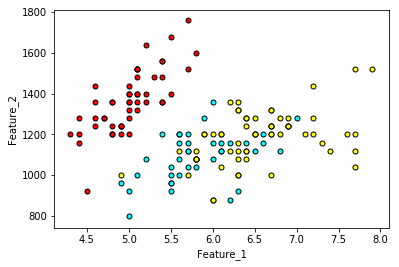

In [2]:
# Importing matplotlib
import matplotlib.pyplot as plt

# Function to help us plot
def plot_points(dataset):
    X = np.array(dataset[["feature1","feature2"]])
    y = np.array(dataset["class"])
    
    people = X[np.argwhere(y==0)]
    cat = X[np.argwhere(y==1)]
    dog = X[np.argwhere(y==2)]
    
    plt.scatter([s[0][0] for s in people], [s[0][1] for s in people], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in cat], [s[0][1] for s in cat], s = 25, color = 'cyan', edgecolor = 'k')
    plt.scatter([s[0][0] for s in dog], [s[0][1] for s in dog], s = 25, color = 'yellow', edgecolor = 'k')
    
    plt.xlabel('Feature_1')
    plt.ylabel('Feature_2')
    
# Plotting the points
plot_points(dataset)
plt.show()

图上红色是人，青色是小猫，黄色是小狗。
粗略来说，这两个feature并没有很好地分离图像小狗，小猫和人。 也许将另两个features考虑进来会有帮助？ 
接下来我们将绘制一组图，用seaborn的pairplot函数来试试吧！

https://seaborn.pydata.org/generated/seaborn.pairplot.html

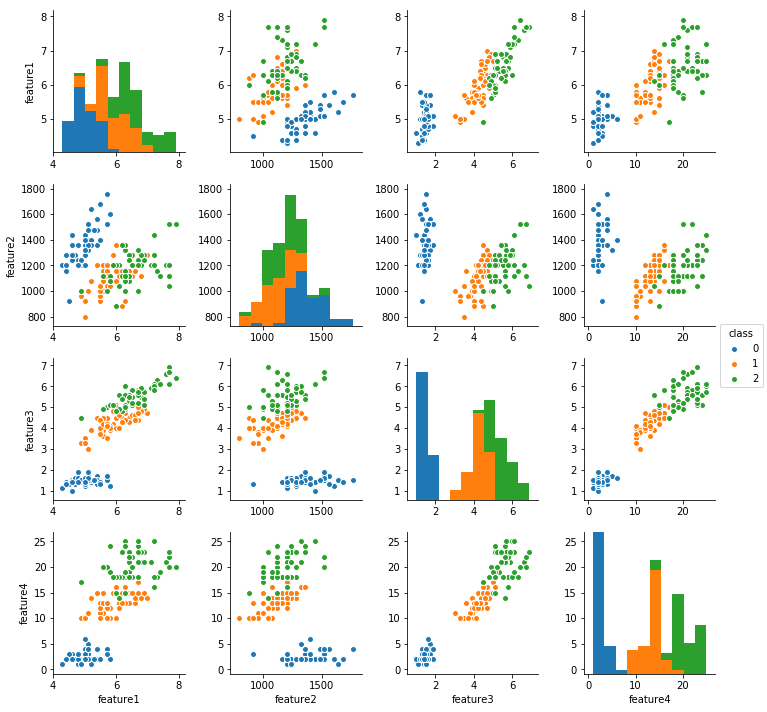

In [3]:
# plotting high-dimensional
import seaborn as sns

sns.pairplot(dataset, hue='class', vars=["feature1","feature2","feature3","feature4"])

图上class=0，代表是人；1代表是猫猫；2代表是狗狗；

## 任务1: 将训练集拆分成自变量data及应变量标签label的组合

数据集中['feature1','feature2','feature3','feature4']是自变量data；

['class']则是应变量标签label；

可参考使用pandas中的iloc，loc用法。

https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.iloc.html

https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.loc.html

In [4]:
# separate dataset into data - feature table and label table
data = dataset.loc[:,['feature1','feature2','feature3','feature4']]

label = dataset.loc[:,['class']]

display(data[:10])
display(label[:10])

,feature1,feature2,feature3,feature4
0,5.1,1400.0,1.4,2.0
1,4.9,1200.0,1.4,2.0
2,4.7,1280.0,1.3,2.0
3,4.6,1240.0,1.5,2.0
4,5.0,1440.0,1.4,2.0
5,5.4,1560.0,1.7,4.0
6,4.6,1360.0,1.4,3.0
7,5.0,1360.0,1.5,2.0
8,4.4,1160.0,1.4,2.0
9,4.9,1240.0,1.5,1.0


,class
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## 任务2: 将评级进行 One-hot 编码

为了实现softmax的概率分布，我们将使用Pandas 中的 `get_dummies` 函数来对label进行One-hot编码。

### 问题1: one-hot编码的作用是什么呢？

回答：one-hot可以使各个元素之间没有优先级关系，都是平等的。

In [5]:
# TODO:  Make dummy variables for rank
# s = ['class_0','class_1','class_2']
dummy_label = pd.get_dummies(label['class'], prefix='class')

# Print the first 10 rows of our data
dummy_label[:10]

,class_0,class_1,class_2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
5,1,0,0
6,1,0,0
7,1,0,0
8,1,0,0
9,1,0,0


## 任务3: 数据标准化


由于神经网络是计算权重，因此我们需要对数据进行标准化的预处理。
我们注意到feature2和feature4的范围比feature1和feature3要大很多，这意味着我们的数据存在偏差，使得神经网络很难处理。 让我们将两个特征缩小，使用(x-min)/(max-min))来将特征归到(0, 1)。

In [6]:
# TODO: Scale the columns
data['feature2'] = (data['feature2']-data['feature2'].min()) / (data['feature2'].max()-data['feature2'].min())
data['feature4'] = (data['feature4']-data['feature4'].min()) / (data['feature4'].max()-data['feature4'].min())
# data['feature2'] = (data['feature2'] - min(data['feature2']))   /  (max(data['feature2']) - min(data['feature2']))
# data['feature4'] = (data['feature4'] - min(data['feature4']))   /  (max(data['feature4']) - min(data['feature4']))


# Printing the first 10 rows of our procesed data
data[:10]

,feature1,feature2,feature3,feature4
0,5.1,0.625000,1.4,0.041667
1,4.9,0.416667,1.4,0.041667
2,4.7,0.500000,1.3,0.041667
3,4.6,0.458333,1.5,0.041667
4,5.0,0.666667,1.4,0.041667
5,5.4,0.791667,1.7,0.125000
6,4.6,0.583333,1.4,0.083333
7,5.0,0.583333,1.5,0.041667
8,4.4,0.375000,1.4,0.041667
9,4.9,0.458333,1.5,0.000000


## 任务4: 将数据分成训练集和测试集

为了测试我们的算法，我们将数据分为训练集和测试集。 测试集的大小将占总数据的 10％。

你可以使用numpy.random.choice或者sklearn.model_selection.train_test_split函数。

https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

#### 问题2: 拆分测试集的目的是什么？还有其他的拆分方式吗？

你的回答：拆分测试集的目的是对训练模型进行检查，看模型的泛化性能如何，是否达到预期效果。

In [7]:
# TODO: split train and test dataset
import sklearn.model_selection
# from sklearn.model_selection import train_test_split
# train_data, test_data = sklearn.model_selection.train_test_split(data,test_size = 0.2)
# train_label, test_label = sklearn.model_selection.train_test_split(dummy_label, test_size = 0.2)
# train_data, test_data, train_label, test_label = train_test_split(data, dummy_label, test_size=0.2)
# train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, dummy_label, test_size=0.2)

train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, dummy_label,test_size = 0.1)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])
print(train_label[:10])
print(test_label[:10])

Number of training samples is 135
Number of testing samples is 15
     feature1  feature2  feature3  feature4
39        5.1  0.583333       1.5  0.041667
131       7.9  0.750000       6.4  0.791667
25        5.0  0.416667       1.6  0.041667
1         4.9  0.416667       1.4  0.041667
52        6.9  0.458333       4.9  0.583333
142       5.8  0.291667       5.1  0.750000
92        5.8  0.250000       4.0  0.458333
63        6.1  0.375000       4.7  0.541667
121       5.6  0.333333       4.9  0.791667
79        5.7  0.250000       3.5  0.375000
     feature1  feature2  feature3  feature4
147       6.5  0.416667       5.2  0.791667
85        6.0  0.583333       4.5  0.625000
4         5.0  0.666667       1.4  0.041667
76        6.8  0.333333       4.8  0.541667
90        5.5  0.250000       4.4  0.458333
136       6.3  0.583333       5.6  0.958333
80        5.5  0.166667       3.8  0.416667
123       6.3  0.291667       4.9  0.708333
62        6.0  0.083333       4.0  0.375000
75        

## 任务5: 训练多分类的神经网络
下列函数会训练二层神经网络。 首先，我们将写一些 helper 函数。
- Softmax 激活函数

$$\sigma(x) = \frac{e^{x_i}} {\sum_{i=1}^{p} e^{x_i}}$$

p指代x的特征数量；

softmax函数常用于多分类目标的模型，他会把所有的output对sum(output)进行均一化，用于减少模型预测偏差。https://zh.wikipedia.org/wiki/Softmax%E5%87%BD%E6%95%B0

sigmoid函数常用于二分类目标的模型，他会将离散数值转换为概率数值。https://zh.wikipedia.org/wiki/S%E5%87%BD%E6%95%B0

- 误差函数导数

$$ loss-derivative = - {\sum_{i=1}^{m} ({y_i} * \log{\hat{y_i}})}$$

m 为 分类的类别数。


In [8]:
# TODO: Activation (softmax) function
def softmax(x):
    expL = np.exp(x)
    return np.divide(expL, expL.sum())
#     return np.divide(expL, np.sum(expL))

# version1:
#     return np.exp(x) / np.sum(np.exp(x))
# version2:
#     return np.exp(x) / np.exp(x).sum(axis=0)
# version :
    return np.exp(x) / np.exp(x).sum(axis=0)

    

def loss_function(x,y,y_hat):

    loss = -((y * np.log10(y_hat)).sum())
#     loss = - np.sum( y * np.log(y_hat) )
    return loss


# 反向误差传递函数

现在轮到你来练习，编写误差项。 记住这是由方程 
$$  - {x  \cdot ({y - \hat{y}})} $$ 给出的。

这里显示了此项目的softmax网络结构。
![alt text](softmax.png "softmax")

下图是softmax的输出模型概览。
![alt text](softmax_model.png "softmax")

In [9]:
# TODO: Write the error term formula
def error_term_formula(x, y, y_hat): 
    
#     x = x.reshape(4,1)
#     return x*((y_hat-y).reshape(1,3))
#     return -(y - y_hat) * y_hat * (1 - y_hat)
    return np.dot (  x.reshape(4, 1), (y - y_hat).reshape(1, 3) )

In [10]:
# Training function
def train_nn(features, targets, epochs, learnrate):
    
    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize weights
    weights = np.zeros([features.shape[1],targets.shape[1]])
    print(weights.shape)

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        loss = []
        for x, y in zip(features.values, targets.values):
            # Loop through all records, x is the input, y is the target

            # Activation of the output unit
            #   Notice we multiply the inputs and the weights here 
            #   rather than storing h as a separate variable 
            output = softmax(np.dot(x, weights))
#             print(output)
#             print((np.dot(x,weights)).shape)
            # The error, the target minus the network output
            error = loss_function(x, y, output)
            loss.append(error)
            # The error term           
            error_term = error_term_formula(x, y, output)
            #print(weights.shape)
            del_w += error_term
            
        # Update the weights here. The learning rate times the 
        # change in weights, divided by the number of records to average
        weights += learnrate * del_w / n_records

        # Printing out the mean square error on the training set
        if e % (epochs / 10) == 0:
            
            out = softmax(np.dot(x, weights))
#             print(out)
            loss = np.mean(np.array(loss))
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            loss = []
            print("=========")
    print(del_w.shape)
    print("Finished training!")
    return weights
 

## 任务6: 训练你的神经网络

设置你的超参数，训练你的神经网络

### 问题3: learnrate的设置有什么技巧？

回答：按照一定规律进行尝试，如0.1，0.01， 0.001

In [11]:
# TODO: SET Neural Network hyperparameters
epochs = 1000
learnrate = 0.1
weights = train_nn(train_data, train_label, epochs, learnrate)

(4, 3)
Epoch: 0
Train loss:  0.47712125472
Epoch: 100
Train loss:  0.181693967728
Epoch: 200
Train loss:  0.146067179993
Epoch: 300
Train loss:  0.126331386548
Epoch: 400
Train loss:  0.113343015084
Epoch: 500
Train loss:  0.104117112973
Epoch: 600
Train loss:  0.0972283107021
Epoch: 700
Train loss:  0.0918905965843
Epoch: 800
Train loss:  0.0876332461259
Epoch: 900
Train loss:  0.0841573838136
(4, 3)
Finished training!


## 任务7:计算测试 (Test) 数据的精确度

现在你的结果是One-Hot编号后的，想想如何获取的精度上的比较？

In [12]:
test_label.head()

,class_0,class_1,class_2
147,0,0,1
85,0,1,0
4,1,0,0
76,0,1,0
90,0,1,0


In [13]:
dummy_label.head()

,class_0,class_1,class_2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [14]:
# TODO: Calculate accuracy on test data
right = 0
test_out = softmax(np.dot(test_data, weights))
for index, out in enumerate(test_out):
    pred = np.argmax(out)
    gt = np.argmax(test_label.as_matrix()[index])
    if gt == pred:
        right += 1

accuracy = right / 15
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.867


## 任务8:用你的神经网络来预测图像是什么

在“images/”路径下有两张图片，我们已经使用通过图像提取特征的方式，分别得到了他们的4个feature值，存储在“validations.csv”中。

下面就由你来试试，看看你的神经网络能不能准确的预测他们吧！

In [15]:
def predict(features):
    return np.argmax(softmax(np.dot(features, weights)))

In [16]:
# TODO: Open the 'validations.csv' file and predict the label. 
# Remember, 0 = people, 1 = cat, 2 = dog

id_to_obj = ['people', 'cat', 'dog']

val_data = pd.read_csv('images/validations.csv')

# val_data['feature2'] = (val_data['feature2'] - feature_2_train_min)   /  (feature_2_train_max - feature_2_train_min)
# val_data['feature4'] = (val_data['feature4'] - feature_4_train_min)   /  (feature_4_train_max - feature_4_train_min)

val_data['feature2'] = (val_data['feature2'] - min(val_data['feature2']))   /  (max(val_data['feature2']) - min(val_data['feature2']))
val_data['feature4'] = (val_data['feature4'] - min(val_data['feature4']))   /  (max(val_data['feature4']) - min(val_data['feature4']))


features = val_data.loc[:, val_data.columns != 'class']
label = val_data.loc[:, val_data.columns == 'class'].as_matrix()

features = features.as_matrix()

predictions = np.zeros_like(label)
for i in range(features.shape[0]):
    print( "The {}th image is {}".format(i, id_to_obj[predict(features[i])]))  


The 0th image is dog
The 1th image is dog


## 任务9:（选做）神经网络分类算法的拓展应用

经过上面的神经网络训练，我们已经得到一个可以猜对三个对象的网络了！

如果想让你的神经网络判断更多的对象，我们就需要提供更多有标签的数据供他学习。

同时，我们也要教会我们的神经网络什么是特征（这个部分，我们已经帮你做好了:)）。当我们把神经网络变得更深的时候，多层的神经网络就可以用来提取图像中的特征了！在正式的课程中，我们就会接触到深层网络的实现。

在这里，我们先借一个已经训练好能够识别1000个物体的网络来完成“你拍，我猜”的神奇功能吧。你可以随便上传一张照片到“images”的文件夹下，我们的神经网络就可以根据已经学习好的权重来猜你拍的照片是什么哦！快来试试吧！

Using TensorFlow backend.


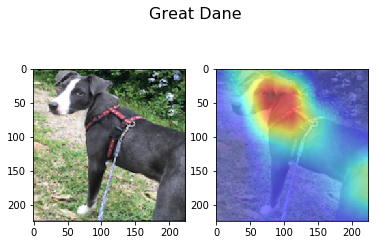

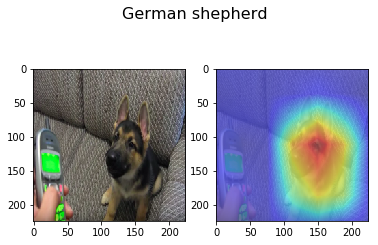

In [17]:
from ResNet_CAM import *
import glob

lists = glob.glob('images/*.png')

# TODO: Upload your image or pick up any image in the folder 'images/xx.png'
for img_path in lists:
    fig, (ax1, ax2) = plt.subplots(1,2)
    CAM = plot_CAM(img_path,ax1,ax2,fig)
    plt.show()